In [9]:
require 'nn'
require 'image'
local ParamBank = require 'ParamBank'

local SpatialConvolution = nn.SpatialConvolution
local SpatialConvolutionMM = nn.SpatialConvolutionMM
local SpatialMaxPooling = nn.SpatialMaxPooling

local cuda = false;

if cuda then
   require 'cunn'
   require 'cudnn'
   SpatialConvolution = cudnn.SpatialConvolution
   SpatialConvolutionMM = cudnn.SpatialConvolution
   SpatialMaxPooling = cudnn.SpatialMaxPooling
end

-- OverFeat input arguements
network  = 'small' or 'big'

-- system parameters
local threads = 4
local offset  = 0

torch.setdefaulttensortype('torch.FloatTensor')
torch.setnumthreads(threads)
print('==> #threads:', torch.getnumthreads())


local function nilling(module)
   module.gradBias   = nil
   if module.finput then module.finput = torch.Tensor():typeAs(module.finput) end
   module.gradWeight = nil
   module.output     = torch.Tensor():typeAs(module.output)
   module.fgradInput = nil
   module.gradInput  = nil
end

local function netLighter(network)
   nilling(network)
   if network.modules then
      for _,a in ipairs(network.modules) do
         netLighter(a)
      end
   end
end


net = nn.Sequential()
local m = net.modules
if network == 'small' then
   print('==> init a small overfeat network')
   net:add(SpatialConvolution(3, 96, 11, 11, 4, 4))
   net:add(nn.Threshold(0, 1e-6))
   net:add(SpatialMaxPooling(2, 2, 2, 2))
   net:add(SpatialConvolutionMM(96, 256, 5, 5, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(SpatialMaxPooling(2, 2, 2, 2))
   net:add(nn.SpatialZeroPadding(1, 1, 1, 1))
   net:add(SpatialConvolutionMM(256, 512, 3, 3, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(nn.SpatialZeroPadding(1, 1, 1, 1))
   net:add(SpatialConvolutionMM(512, 1024, 3, 3, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(nn.SpatialZeroPadding(1, 1, 1, 1))
   net:add(SpatialConvolutionMM(1024, 1024, 3, 3, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(SpatialMaxPooling(2, 2, 2, 2))
   net:add(SpatialConvolutionMM(1024, 3072, 6, 6, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(SpatialConvolutionMM(3072, 4096, 1, 1, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(SpatialConvolutionMM(4096, 1000, 1, 1, 1, 1))
   net:add(nn.View(1000))
   net:add(nn.SoftMax())
   net = net:float()
   print(net)

   -- init file pointer
   print('==> overwrite network parameters with pre-trained weigts')
   ParamBank:init("net_weight_0")
   ParamBank:read(        0, {96,3,11,11},    m[offset+1].weight)
   ParamBank:read(    34848, {96},            m[offset+1].bias)
   ParamBank:read(    34944, {256,96,5,5},    m[offset+4].weight)
   ParamBank:read(   649344, {256},           m[offset+4].bias)
   ParamBank:read(   649600, {512,256,3,3},   m[offset+8].weight)
   ParamBank:read(  1829248, {512},           m[offset+8].bias)
   ParamBank:read(  1829760, {1024,512,3,3},  m[offset+11].weight)
   ParamBank:read(  6548352, {1024},          m[offset+11].bias)
   ParamBank:read(  6549376, {1024,1024,3,3}, m[offset+14].weight)
   ParamBank:read( 15986560, {1024},          m[offset+14].bias)
   ParamBank:read( 15987584, {3072,1024,6,6}, m[offset+17].weight)
   ParamBank:read(129233792, {3072},          m[offset+17].bias)
   ParamBank:read(129236864, {4096,3072,1,1}, m[offset+19].weight)
   ParamBank:read(141819776, {4096},          m[offset+19].bias)
   ParamBank:read(141823872, {1000,4096,1,1}, m[offset+21].weight)
   ParamBank:read(145919872, {1000},          m[offset+21].bias)

elseif network == 'big' then
   print('==> init a big overfeat network')
   net:add(SpatialConvolution(3, 96, 7, 7, 2, 2))
   net:add(nn.Threshold(0, 1e-6))
   net:add(SpatialMaxPooling(3, 3, 3, 3))
   net:add(SpatialConvolutionMM(96, 256, 7, 7, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(SpatialMaxPooling(2, 2, 2, 2))
   net:add(nn.SpatialZeroPadding(1, 1, 1, 1))
   net:add(SpatialConvolutionMM(256, 512, 3, 3, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(nn.SpatialZeroPadding(1, 1, 1, 1))
   net:add(SpatialConvolutionMM(512, 512, 3, 3, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(nn.SpatialZeroPadding(1, 1, 1, 1))
   net:add(SpatialConvolutionMM(512, 1024, 3, 3, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(nn.SpatialZeroPadding(1, 1, 1, 1))
   net:add(SpatialConvolutionMM(1024, 1024, 3, 3, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(SpatialMaxPooling(3, 3, 3, 3))
   net:add(SpatialConvolutionMM(1024, 4096, 5, 5, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(SpatialConvolutionMM(4096, 4096, 1, 1, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(SpatialConvolutionMM(4096, 1000, 1, 1, 1, 1))
   net:add(nn.View(1000))
   net:add(nn.SoftMax())
   net = net:float()
   print(net)

   -- init file pointer
   print('==> overwrite network parameters with pre-trained weigts')
   ParamBank:init("net_weight_1")
   ParamBank:read(        0, {96,3,7,7},      m[offset+1].weight)
   ParamBank:read(    14112, {96},            m[offset+1].bias)
   ParamBank:read(    14208, {256,96,7,7},    m[offset+4].weight)
   ParamBank:read(  1218432, {256},           m[offset+4].bias)
   ParamBank:read(  1218688, {512,256,3,3},   m[offset+8].weight)
   ParamBank:read(  2398336, {512},           m[offset+8].bias)
   ParamBank:read(  2398848, {512,512,3,3},   m[offset+11].weight)
   ParamBank:read(  4758144, {512},           m[offset+11].bias)
   ParamBank:read(  4758656, {1024,512,3,3},  m[offset+14].weight)
   ParamBank:read(  9477248, {1024},          m[offset+14].bias)
   ParamBank:read(  9478272, {1024,1024,3,3}, m[offset+17].weight)
   ParamBank:read( 18915456, {1024},          m[offset+17].bias)
   ParamBank:read( 18916480, {4096,1024,5,5}, m[offset+20].weight)
   ParamBank:read(123774080, {4096},          m[offset+20].bias)
   ParamBank:read(123778176, {4096,4096,1,1}, m[offset+22].weight)
   ParamBank:read(140555392, {4096},          m[offset+22].bias)
   ParamBank:read(140559488, {1000,4096,1,1}, m[offset+24].weight)
   ParamBank:read(144655488, {1000},          m[offset+24].bias)

end
-- close file pointer
ParamBank:close()



==> #threads:	4	
==> init a small overfeat network	


nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> (12) -> (13) -> (14) -> (15) -> (16) -> (17) -> (18) -> (19) -> (20) -> (21) -> (22) -> (23) -> output]
  (1): nn.SpatialConvolution
  (2): nn.Threshold
  (3): nn.SpatialMaxPooling
  (4): nn.SpatialConvolutionMM
  (5): nn.Threshold
  (6): nn.SpatialMaxPooling
  (7): nn.SpatialZeroPadding
  (8): nn.SpatialConvolutionMM
  (9): nn.Threshold
  (10): nn.SpatialZeroPadding
  (11): nn.SpatialConvolutionMM
  (12): nn.Threshold
  (13): nn.SpatialZeroPadding
  (14): nn.SpatialConvolutionMM
  (15): nn.Threshold
  (16): nn.SpatialMaxPooling
  (17): nn.SpatialConvolutionMM
  (18): nn.Threshold
  (19): nn.SpatialConvolutionMM
  (20): nn.Threshold
  (21): nn.SpatialConvolutionMM
  (22): nn.View
  (23): nn.SoftMax
}
{
  output : FloatTensor - empty
  gradInput : FloatTensor - empty
  modules : 
    {
      1 : 
        nn.SpatialConvolution
        {
          bias : FloatTensor - size: 96
      

nn.Threshold
        {
          val : 1e-06
          output : FloatTensor - empty
          gradInput : FloatTensor - empty
          threshold : 0
        }
      3 : 
        nn.SpatialMaxPooling
        {
          kW : 2
          kH : 2
          indices : FloatTensor - empty
          dW : 2
          gradInput : FloatTensor - empty
          output : FloatTensor - empty
          dH : 2
        }
      4 : 
        nn.SpatialConvolutionMM
        {
          padding : 0
          kW : 5
          nInputPlane : 96
          gradBias : FloatTensor - size: 256
          dW : 1
          gradWeight : FloatTensor - size: 256x2400
          output : FloatTensor - empty
          fgradInput : FloatTensor - empty
          finput : FloatTensor - empty
          bias : FloatTensor - size: 256
          weight : FloatTensor - size: 256x2400
          nOutputPlane : 256
          gradInput : FloatTensor - empty
          kH : 5
          dH : 1
        }
      5 : 
        nn.Threshold
 

        kH : 2
          indices : FloatTensor - empty
          dW : 2
          gradInput : FloatTensor - empty
 

         output : FloatTensor - empty
          dH : 2
        }
      7 : 
        nn.SpatialZeroPadding
        {
          pad_l : 1
          gradInput : FloatTensor - empty
          pad_t : 1
          pad_b : 1
          pad_r : 1
          output : FloatTensor - empty
        }
      8 : 
        nn.SpatialConvolutionMM
        {
          padding : 0
          kW : 3
          nInputPlane : 256
          gradBias : FloatTensor - size: 512
          dW : 1
          gradWeight : FloatTensor - size: 512x2304
          output : FloatTensor - empty
          fgradInput : FloatTensor - empty
          finput : FloatTensor - empty
         

 bias : FloatTensor - size: 512
          weight : FloatTensor - size: 512x2304
          nOutputPlane : 512
          gradInput : FloatTensor - empty
          kH : 3
          dH : 1
        }
      9 : 
        nn.Threshold
        {
          val : 1e-06
          output : FloatTensor - empty
          gradInput : FloatTensor - empty
          threshold : 0
        }
      10 : 
        nn.SpatialZeroPadding
        {
          pad_l : 1
          gradInput : FloatTensor - empty
          pad_t : 1
          pad_b : 1
          pad_r : 1
          output : FloatTensor - empty
        }
      11 : 
        nn.SpatialConvolutionMM
        {
          padding : 0
          kW : 3
          nInputPlane : 512
          gradBias : FloatTensor - size: 1024
          dW : 1
          gradWeight : FloatTensor - size: 1024x4608
          output : FloatTensor - empty
          fgradInput : FloatTensor - empty
          finput : FloatTensor - empty
          bias : FloatTensor - size: 1024
   


          kW : 3
          nInputPlane : 1024
          gradBias : FloatTensor - size: 1024
          dW : 1
          gradWeight : FloatTensor - size: 1024x9216
          output : FloatTensor - empty
          fgradInput : FloatTensor - empty
          finput : FloatTensor - empty
          bias : FloatTensor - size: 1024
          weight : FloatTensor - size: 1024x9216
          nOutputPlane : 1024
          gradInput : FloatTensor - empty
          kH : 3
          dH : 1
        }
      15 : 
        nn.Threshold
        {
          val : 1e-06
          output : FloatTensor - empty
          gradInput : FloatTensor - empty
          threshold : 0
        }
      16 : 
        nn.SpatialMaxPooling
        {
          kW : 2
          kH : 2
          indices : FloatTensor - empty
          dW : 2
          gradInput : FloatTensor - empty
          output : FloatTensor - empty
          dH : 2
        }
      17 : 
        nn.SpatialConvolutionMM
        {
          padding : 0
   

          gradInput : FloatTensor - empty
          kH : 6
          dH : 1


        }
      18 : 
        nn.Threshold
        {
          val : 1e-06
          output : FloatTensor - empty
          gradInput : FloatTensor - empty
          threshold : 0
        }
      19 : 
        nn.SpatialConvolutionMM
        {
          padding : 0
          kW : 1
          nInputPlane : 3072
          gradBias : FloatTensor - size: 4096
          dW : 1
          gradWeight : FloatTensor - size: 4096x3072
          output : FloatTensor - empty
          fgradInput : FloatTensor - empty
          finput : FloatTensor - empty
          bias : FloatTensor - size: 4096
          weight : FloatTensor - size: 4096x3072
          nOutputPlane : 4096
          gradInput : FloatTensor - empty
          kH : 1
          dH : 1
        }
      20 : 
        nn.Threshold
        {
          val : 1e-06
          output : FloatTensor - empty
          gradInput : FloatTensor - empty
          threshold : 0
        }
      21 : 
        nn.SpatialConvolutionMM
        {


          padding : 0
          kW : 1
          nInputPlane : 4096
          gradBias : FloatTensor - size: 1000
          dW : 1
          gradWeight : FloatTensor - size: 1000x4096
          output : FloatTensor - empty
         

 fgradInput : FloatTensor - empty
          finput : FloatTensor - empty
          bias : FloatTensor - size: 1000
          weight : FloatTensor - size: 1000x4096
          nOutputPlane : 1000
          gradInput : FloatTensor - empty
          kH : 1
          dH : 1
        }
      22 : 
        nn.View
        {
          numElements : 1000
          size : LongStorage - size: 1
        }
      23 : 
        nn.SoftMax
        {
          gradInput : FloatTensor - empty
          output : FloatTensor - empty
        }
    }
}
==> overwrite network parameters with pre-trained weigts	


In [11]:
local label     = require 'overfeat_label'
local filename = 'bee.jpg'

if cuda then net:cuda() end

-- load and preprocess image
print('==> prepare an input image')
local img_dim
if network == 'small' then    dim = 231
elseif network == 'big' then  dim = 221 end
local img_raw = image.load(filename):mul(255)
local rh = img_raw:size(2)
local rw = img_raw:size(3)
if rh < rw then
   rw = math.floor(rw / rh * dim)
   rh = dim
else
   rh = math.floor(rh / rw * dim)
   rw = dim
end
local img_scale = image.scale(img_raw, rw, rh)

local offsetx = 1
local offsety = 1
if rh < rw then
   offsetx = offsetx + math.floor((rw-dim)/2)
else
   offsety = offsety + math.floor((rh-dim)/2)
end
img = img_scale[{{},{offsety,offsety+dim-1},{offsetx,offsetx+dim-1}}]:floor()


-- feedforward network
print('==> feed the input image')
timer = torch.Timer()
img:add(-118.380948):div(61.896913)  -- fixed distn ~ N(118.380948, 61.896913^2)
if cuda then 
   img = img:cuda():view(1, img:size(1), img:size(2), img:size(3))
   local out = net:forward(img):clone():float()
   prob, idx = torch.max(out[1], 1)
else
   prob, idx = torch.max(net:forward(img), 1)
end
print(label[idx:squeeze()], prob:squeeze())
print('Time elapsed: ' .. timer:time().real .. ' seconds')

==> prepare an input image	
==> feed the input image	
bee	0.86844658851624	
Time elapsed: 0.54240608215332 seconds	


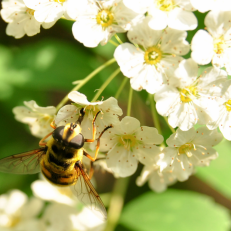

 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000


 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0001
 0.0000
 0.0000
 0.0000
 0.0006
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0150
 0.0000
 0.0183
 0.0463
 0.0000
 0.0000
 0.0017
 0.0387
 0.8684
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000


In [30]:
itorch.image(img)
output = net:forward(img)
--confidence, index = output:float():sort(confidence, 1, true)
confidence, index = output:float()
print(confidence, index)

In [52]:
local label     = require 'overfeat_label'
predictions = {}
output2 = output:float()
for i=1,output2:size()[1] do
    --predictions[i] = output[i]
    table.insert(predictions, {category_id=i, label=label[i], confidence=output2[i]})
end
table.sort(predictions, function(a,b) return a.confidence > b.confidence end)
print(predictions);

{
  1 : 
    {
      category_id : 630
      label : bee
      confidence : 0.86844658851624
    }
  2 : 
    {
      category_id : 625
      label : leaf beetle, chrysomelid
      confidence : 0.046323519200087
    }
  3 : 
    {
      category_id : 629
      label : fly
      confidence : 0.038696032017469
    }
  4 : 
    {
      category_id : 624
      label : long-horned beetle, longicorn, longicorn beetle
      confidence : 0.018285298720002
    }
  5 : 
    {
      category_id : 622
      label : ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle
      confidence : 0.014956210739911
    }
  6 : 
    {
      category_id : 224
      label : ant, emmet, pismire
      confidence : 0.0057858200743794
    }
  7 : 
    {
      category_id : 357
      label : daisy
      confidence : 0.0026141235139221
    }
  8 : 
    {
      category_id : 628
      label : weevil
      confidence : 0.0016533345915377
    }
  9 : 
    {
      category_id : 606
      label : garden spider, Aran

e-06
    }
  36 : 
    {
      category_id : 639
      label : dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk
      confidence : 2.9916645871708e-06
    }
  37 : 
    {
      category_id : 722
      label : picket fence, paling
      confidence : 2.7315020361129e-06
    }
  38 : 
    {
      category_id : 605
      label : barn spider, Araneus cavaticus
      confidence : 2.4625348942209e-06
    }
  39 : 
    {
      category_id : 658
      label : sea cucumber, holothurian
      confidence : 0
    }
  40 : 
    {
      category_id : 656
      label : chiton, coat-of-mail shell, sea cradle, polyplacophore
      confidence : 0
    }
  41 : 
    {
      category_id : 657
      label : sea urchin
      confidence : 0
    }
  42 : 
    {
      category_id : 660
      label : espresso maker
      confidence : 0
    }
  43 : 
    {
      category_id : 659
      label : iron, smoothing iron
      confidence : 0
    }
 

id : 649
      label : brain coral
      confidence : 0
    }
  77 : 
    {
      category_id : 648
      label : sea anemone, anemone
      confidence : 0
    }
  78 : 
    {
      category_id : 732
      label : pedestal, plinth, footstall
      confidence : 0
    }
  79 : 
    {
      category_id : 733
      label : beacon, lighthouse, beacon light, pharos
      confidence : 0
    }
  80 : 
    {
      category_id : 647
      label : jellyfish
      confidence : 0
    }
  81 : 
    {
      category_id : 671
      label : frying pan, frypan, skillet
      confidence : 0
    }
  82 : 
    {
      category_id : 672
      label : wok
      confidence : 0
    }
  83 : 
    {
      category_id : 673
      label : caldron, cauldron
      confidence : 0
    }
  84 : 
    {
      category_id : 706
      label : bookshop, bookstore, bookstall
      confidence : 0
    }
  85 : 
    {
      category_id : 705
      label : barbershop
      confidence : 0
    }
  86 : 
    {
      category_id : 7

ct
      confidence : 0
    }
  116 : 
    {
      category_id : 676
      label : spatula
      confidence : 0
    }
  117 : 
    {
      category_id : 724
      label : stone wall
      confidence : 0
    }
  118 : 
    {
      category_id : 675
      label : teapot
      confidence : 0
    }
  119 : 
    {
      category_id : 725
      label : grille, radiator grille
      confidence : 0
    }
  120 : 
    {
      category_id : 674
      label : coffeepot
      confidence : 0
    }
  121 : 
    {
      category_id : 696
      label : home theater, home theatre
      confidence : 0
    }
  122 : 
    {
      category_id : 683
      label : barn
      confidence : 0
    }
  123 : 
    {
      category_id : 685
      label : palace
      confidence : 0
    }
  124 : 
    {
      category_id : 692
      label : stupa, tope
      confidence : 0
    }
  125 : 
    {
      category_id : 691
      label : mosque
      confidence : 0
    }
  126 : 
    {
      category_id : 693
      label :

tegory_id : 560
      label : joystick
      confidence : 0
    }
  157 : 
    {
      category_id : 549
      label : slide rule, slipstick
      confidence : 0
    }
  158 : 
    {
      category_id : 556
      label : printer
      confidence : 0
    }
  159 : 
    {
      category_id : 554
      label : harvester, reaper
      confidence : 0
    }
  160 : 
    {
      category_id : 551
      label : hand-held computer, hand-held microcomputer
      confidence : 0
    }
  161 : 
    {
      category_id : 555
      label : thresher, thrasher, threshing machine
      confidence : 0
    }
  162 : 
    {
      category_id : 552
      label : notebook, notebook computer
      confidence : 0
    }
  163 : 
    {
      category_id : 553
      label : web site, website, internet site, site
      confidence : 0
    }
  164 : 
    {
      category_id : 562
      label : hook, claw
      confidence : 0
    }
  165 : 
    {
      category_id : 534
      label : projector
      confidence : 0
  

ns
      confidence : 0
    }
  198 : 
    {
      category_id : 603
      label : scorpion
      confidence : 0
    }
  199 : 
    {
      category_id : 608
      label : tarantula
      confidence : 0
    }
  200 : 
    {
      category_id : 610
      label : tick
      confidence : 0
    }
  201 : 
    {
      category_id : 609
      label : wolf spider, hunting spider
      confidence : 0
    }
  202 : 
    {
      category_id : 611
      label : centipede
      confidence : 0
    }
  203 : 
    {
      category_id : 601
      label : trilobite
      confidence : 0
    }
  204 : 
    {
      category_id : 598
      label : maypole
      confidence : 0
    }
  205 : 
    {
      category_id : 595
      label : neck brace
      confidence : 0
    }
  206 : 
    {
      category_id : 599
      label : mousetrap
      confidence : 0
    }
  207 : 
    {
      category_id : 596
      label : pier
      confidence : 0
    }
  208 : 
    {
      category_id : 597
      label : tripod
    

      confidence : 0
    }
  224 : 
    {
      category_id : 564
      label : paddlewheel, paddle wheel
      confidence : 0
    }
  225 : 
   

 {
      category_id : 593
      label : spotlight, spot
      confidence : 0
    }
  226 : 
    {
      category_id : 591
      label : candle, taper, wax light
      confidence : 0
    }
  227 : 
    {
      category_id : 573
      label : hard disc, hard disk, fixed disk
      confidence : 0
    }
  228 : 
    {
      category_id : 572
      label : puck, hockey puck
      confidence : 0
    }
  229 : 
    {
      category_id : 574
      label : sunglass
 

     confidence : 0
    }
  230 : 
    {
      category_id : 576
      label : car mirror
      confidence : 0
    }
  231 : 
    {
      category_id : 575
      label : pick, plectrum, plectron
      confidence : 0
    }
 

 232 : 
    {
      category_id : 577
      label : solar dish, solar collector, solar furnace
      confidence : 0
    }
  233 : 
    {
      category_id : 571
      label : radiator
      confidence : 0
    

}
  234 : 
    {
      category_id : 569
      label : swing
      confidence : 0
    }
  235 : 
    {
      category_id : 566
      label : potter's wheel
      confidence : 0
    }
  236 : 
    {
      category_id : 570
      label : reel
      confidence : 0
    }
  237 : 
    {
      category_id : 567
      label : gas pump, gasoline pump, petrol pump, island dispenser
      confidence : 0
    }
  238 : 
    {
      category_id : 568
      label : carousel, carrousel, merry-go-round, roundabout, whirligig
      confidence : 0
    }
  239 : 
    {
    

  category_id : 592
      label : jack-o'-lantern
      confidence : 0
    }
  240 : 
    {
      category_id : 578
      label : remote control, remote
      confidence : 0
    }
  241 : 
    {
      category_id : 580
      label : buckle
      confidence : 0
    }
  242 : 
    {
      category_id : 588
      label : muzzle
      confidence : 0
    }


  243 : 
    {
      category_id : 587
      label : screw
      confidence : 0
    }
  244 : 
    {
      category_id : 589
      label : seat belt, seatbelt
      confidence : 0
    }
  245 : 
    {
      category_id : 590
      label : ski
      confidence : 0
    }
  246 : 
    {
      category_id : 579
      label : disk brake, disc brake
      confidence : 0
    }
  247 : 
    {
      category_id : 586
      label : safety pin
      confidence : 0
    }
  248 : 
    {
      category_id : 584
      label : padlock
      confidence : 0
    }
  249 : 
    {
      category_id : 581
      label : hair slide
      confidence : 0
    }
  250 : 
    {
      category_id : 585
      label : nail
      confidence : 0
    }
  251 : 
    {
      category_id : 582
      label : knot
      confidence : 0
    }
  252 : 
    {
      

category_id : 583
      label : combination lock
      confidence : 0
    }
  253 : 
    {
      category_id : 747
      label : shower curtain
      confidence : 0
    }
  254 : 
    {
      category_id : 749
      label : carton
      confidence : 0
    }
  255 : 
    {
      category_id : 505
      label : hand blower, blow dryer, blow drier, hair dryer, hair drier
      confidence : 0
    }
  256 : 
    {
      category_id : 917
      label : mailbox, letter box
      confidence : 0
    }
  257 : 
    {
      category_id : 916
      label : barbell
      confidence : 0
    }
  258 : 
    {
      category_id : 918
      label : lab coat, laboratory coat
      confidence : 0
    }
  259 : 
    {
      category_id : 920
      label : minibus
      confidence : 0
    }
  260 : 
    {
      category_id : 919
      label : fire screen, fireguard
      confidence : 0
    }
  261 : 
    {
      category_id : 921
      label : packet
      confidence : 0
    }
  262 : 
    {
      category_

  category_id : 909
      label : bath towel
      confidence : 0
    }
  265 : 
    {
      category_id : 914
      label : cellular telephone, cellular phone, cellphone, cell, mobile phone
      confidence : 0
    }
  266 : 
    {
      category_id : 910
      label : cowboy boot
      confidence : 0
    }
  267 : 
    {
      category_id : 912
      label : window screen
      confidence : 0
    }
  268 : 
    {
      category_id : 911
      label : gown
      confidence : 0
    }
  269 : 
    {
      category_id : 908
      label : basketball
      confidence : 0
    }
  270 : 
    {
      category_id : 922
      label : maze, labyrinth
      confidence : 0
    }
  271 : 
    {
      category_id : 924
      label : horizontal bar, high bar
      confidence : 0
    }
  272 : 
    {
      category_id : 933
      label : bell cote, bell cot
      confidence : 0
    }
  273 : 
    {
      category_id : 932
      label : street sign
      confidence : 0
    }
  274 : 
    {
      catego

    }
  281 : 
    {
      category_id : 930
      label : comic book
      confidence : 0
    }
  282 : 
    {
      category_id : 926
      label : pickelhaube
      confidence : 0
    }
  283 : 
    {
      category_id : 928
      label : wallet, billfold, notecase, pocketbook
      confidence : 0
    }
  284 : 
    {
      category_id : 927
      label : rain barrel
      confidence : 0
    }
  285 : 
    {
      category_id : 937
      label : overskirt
      confidence : 0
    }
  286 : 
    {
      category_id : 907
      label : ballpoint, ballpoint pen, ballpen, Biro
      confidence : 0
    }
  287 : 
    {
      category_id : 905
      label : barrel, cask
      confidence : 0
    }
  288 : 
    {
      category_id : 886
      label : coral fungus
      confidence : 0
    }
  289 : 
    {
      category_id : 885
      label : hotdog, hot dog, red hot
      confidence : 0
    }
  290 : 
    {
      category_id : 887
      label : bullet train, bullet
      confidence : 0
    


      confidence : 0
    }
  322 : 
    {
      category_id : 983
      label : pitcher, ewer
      confidence : 0
    }
  323 : 
    {
      category_id : 982
      label : scuba diver
      confidence : 0
    }
  324 : 
    {
      category_id : 984
      label : matchstick
      confidence : 0
    }
  325 : 
    {
      category_id : 978
      label : tape player
      confidence : 0
    }
  326 : 
    {
      category_id : 976
      label : quilt, comforter, comfort, puff
      confidence : 0
    }
  327 : 
    {
      category_id : 972
      label : doormat, welcome mat
      confidence : 0
    }
  328 : 
    {
      category_id : 977
      label : maillot, tank suit
      confidence : 0
    }
  329 : 
    {
      category_id : 973
      label : Loafer
      confidence : 0
    }
  330 : 
    {
      category_id : 975
      label : pretzel
      confidence : 0
    }
  331 : 
    {
      category_id : 974
      label : ice cream, icecream
      confidence : 0
    }
  332 : 
    {
 

      confidence : 0
    }
  337 : 
    {
      category_id : 996
      label : coffee mug
      confidence : 0
    }
  338 : 
    {
      category_id : 998
      label : stole
      confidence : 0
    }
  339 : 
    {
      category_id : 997
      label : rubber eraser, rubber, pencil eraser
      confidence : 0
    }
  340 : 
    {
      category_id : 986
      label : sock
      confidence : 0
    }
  341 : 
    {
      category_id : 993
      label : cheeseburger
      confidence : 0
    }
  342 : 
    {
      category_id : 991
      label : beaker
      confidence : 0
    }
  343 : 
    {
      category_id : 988
      label : lens cap, lens cover
      confidence : 0
    }
  344 : 
    {
      category_id : 992


      label : bubble
      confidence : 0
    }
  345 : 
    {
      category_id : 989
      label : thatch, thatched roof
      confidence : 0
    }
  346 : 
    {
      category_id : 990
      label : vault
      confidence : 0
    }
  347 : 
    {
      category_id : 939
      label : purse
      confidence : 0
    }
  348 : 
    {
      category_id : 970
      label : tennis ball
      confidence : 0
    }
  349 : 
    {
      category_id : 968
      

label : ice lolly, lolly, lollipop, popsicle
      confidence : 0
    }
  350 : 
    {
      category_id : 949
      label : breastplate, aegis, egis
      confidence : 0
    }
  351 : 
    {
      category_id : 948
      label : pizza, pizza pie
      confidence : 0
    }
  352 : 
    {
      category_id : 950
 

     label : shopping basket
      confidence : 0
    }
  353 : 
    {
      category_id : 952
      label : saltshaker, salt shaker
      confidence : 0
    }
  354 : 
    {
      category_id : 951
      label : wooden spoon
      confidence : 0
    }
  355 : 
    {
      category_id : 953
      label : chocolate sauce, chocolate syrup
      confidence : 0
    }
  356 : 
    {
      category_id : 947


      label : espresso
      confidence : 0
    }
  357 : 
    {


      category_id : 945
      label : swimming trunks, bathing trunks
      confidence : 0
    }
  358 : 
    {
      category_id : 941
      label : bib
      confidence : 0
    }
  359 : 
    {
      category_id : 946
      label : measuring cup
      confidence : 0
    }
  360 : 
    {
      category_id : 942
      label : parachute, chute
      confidence : 0
    }
  361 : 
    {
      category_id : 944
      label : television, television system
      confidence : 0
    }
  362 : 
    {
      category_id : 943
      label : sleeping bag
      confidence : 0
    }
  363 : 
    {
      category_id : 969
      label : velvet
      confidence : 0
    }
  364 : 
    {
      category_id : 954
      label : ballplayer, baseball player
      confidence : 0
    }
  365 : 
    

{
      category_id : 956
      label : gyromitra
      confidence : 0
    }
  366 : 
    {
      category_id : 964
      label : plastic bag
      confidence : 0
    }
  367 : 
    {
      category_id : 963
      label : jigsaw puzzle
      confidence : 0
    }
  368 : 
    {
      category_id : 965
      label : reflex camera
      confidence : 0
    }
  369 : 
    {
      category_id : 967
      label : Band Aid
      confidence : 0
    }
  370 : 
    {
      category_id : 966
      label : diaper, nappy, napkin
      confidence : 0
    }
  371 : 
    {
      category_id : 955
      label : goblet
      confidence : 0
    }
  372 : 
    {
      category_id : 962
      label : school bus
      confidence : 0
    }
  373 : 
    {
      category_id : 960
      label : soap dispenser
      confidence : 0
    }
  374 : 
    {
      category_id : 957
      label : stretcher
      confidence : 0
    }
  375 : 
    {
      category_id : 961
      label : jersey, T-shirt, tee shirt
      con

confidence : 0
    }
  387 : 
    {
      category_id : 787
      label : holster
      confidence : 0
    }
  388 : 
    {
      category_id : 785
      label : bathing cap, swimming cap
      confidence : 0
    }
  389 : 
    {
      category_id : 781
      label : mask
      confidence : 0
    }
  390 : 
    {
      category_id : 786
      label : teddy, teddy bear
      confidence : 0
    }
  391 : 
    {
      category_id : 782
      label : maillot
      confidence : 0
    }
  392 : 
    {
      category_id : 784
      label : football helmet
      confidence : 0
    }
  393 : 
    {
      category_id : 783
      label : Petri dish
      confidence : 0
    }
  394 : 
    {
      category_id : 780
      label : tile roof
      confidence : 0
    }
  395 : 
    {
      category_id : 794
      label : suit, suit of clothes
      confidence : 0
    }
  396 : 
    {
      category_id : 796
      label : feather boa, boa
      confidence : 0
    }
  397 : 
    {
      category_id : 805

      category_id : 809
      label : scabbard
      confidence : 0
    }
  411 : 
    {
      category_id : 779
      label : bottlecap
      confidence : 0
    }
  412 : 
    {
      category_id : 777
      label : beer bottle
      confidence : 0
    }
  413 : 
    {
      category_id : 758
      label : thimble
      confidence : 0
    }
  414 : 
    {
      category_id : 757
      label : fur coat
      confidence : 0
    }
  415 : 
    {
      category_id : 759
      label : pajama, pyjama, pj's, jammies
      confidence : 0
    }
  416 : 
    {
      category_id : 761
   

   label : cocktail shaker


      confidence : 0
    }
  417 : 
    {
      category_id : 760
      label : running shoe
      confidence : 0
    }
  418 : 
    {
      category_id : 762
      label : chest
      confidence : 0
    }
  419 : 
    {
      category_id : 756
      label : croquet ball
      confidence : 0
    }
  420 : 
    {
      category_id : 754
      label : plate
      confidence : 0
    }
  421 : 
    {
      category_id : 750
      label : handkerchief, hankie, hanky, hankey
      confidence : 0
    }
  422 : 
    {
      category_id : 755
      label : necklace
      confidence : 0
    }
  423 : 
    {
   

   category_id : 751
      label : sandal
      confidence : 0
    }
  424 : 
    {
      category_id : 753
      label : safe
      confidence : 0
    }
  425 : 
    {
      category_id : 752
      label : ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin
      confidence : 0
    }
  426 : 
    {
      category_id : 778
      label : crash helmet
      confidence : 0
    }
  427 : 
    {
      category_id : 763
      label : manhole cover
      confidence : 0
    }
  428 : 
    {
      category_id : 765
      label : tub, vat
      confidence : 0
    }
  429 : 
    {
      category_id : 773
      label : knee pad
      confidence : 0
    }
  430 : 
    {
      category_id : 772
      label : whiskey jug
      confidence : 0
    }
  431 : 
    {
      category_id : 774
      label : book jacket, dust cover, dust jacket, dust wrapper
      confidence : 0
    }
  432 : 
    {
      category_id : 776
      label : ski mask
      confidenc

 confidence : 0
    }
  437 : 
    {
      category_id : 766
      label : tray
      confidence : 0
    }
  438 : 
    {
      category_id : 770
      label : kimono
      confidence : 0
    }
  439 : 
    {
      category_id : 767
      label : balance beam, beam
      confidence : 0
    }
  440 : 
    {
      category_id : 768
      label : bagel, beigel
      confidence : 0
    }
  441 : 
    {
      category_id : 873
      label : French loaf
      confidence : 0
    }
  442 : 
    {
      category_id : 810
      label : sunscreen, sunblock, sun blocker
      confidence : 0
    }
  443 : 
    {
      category_id : 812
      label : hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa
      confidence : 0
    }
  444 : 
    {
      category_id : 853
      label : abaya
      confidence : 0
    }
  445 : 
    {
      category_id : 852
      label : mosquito net
      confidence : 0
    }
  446 : 
    {
      category_id : 854
      label : mortarboard
      conf

  confidence : 0
    }
  455 : 
    {
      category_id : 848
      label : groom, bridegroom
      confidence : 0
    }
  456 : 
    {
      category_id : 847
      label : backpack, back pack, knapsack, packsack, rucksack, haversack
      confidence : 0
    }
  457 : 
    {
      category_id : 844
      label : consomme
      confidence : 0
    }
  458 : 
    {
      category_id : 858
      label : space bar
      confidence : 0
    }
  459 : 
    {
      category_id : 860
      label : racket, racquet
      confidence : 0
    }
  460 : 
    {
      category_id : 868
      label : shower cap
      confidence : 0
    }
  461 : 
    {
      category_id : 867
      label : lipstick, lip rouge
      confidence : 0
    }
  462 : 
    {
      category_id : 869
      label : monitor
      confidence : 0
    }
  463 : 
    {
      category_id : 871
      label : mitten
      confidence : 0
    }
  464 : 
    {
      category_id : 870
      label : oscilloscope, scope, cathode-ray oscilloscop

     category_id : 821
      label : dishrag, dishcloth
      confidence : 0
    }
  476 : 
    {
      category_id : 820
      label : bucket, pail
      confidence : 0
    }
  477 : 
    {
      category_id : 822
      label : soup bowl
      confidence : 0
    }
  478 : 
    {
      category_id : 824
      label : mortar
      confidence : 0
    }
  479 : 
    {
      category_id : 823
      label : eggnog
      confidence : 0
    }
  480 : 
    {
      category_id : 825
      label : trench coat
      confidence : 0
    }
  481 : 
    {
      category_id : 819
      label : water jug
      confidence : 0
    }
  482 : 
    {
      category_id : 817
      label : bow tie, bow-tie, bowtie
      confidence : 0
    }
  483 : 
    {
      category_id : 813
      label : guacamole
      confidence : 0
    }
  484 : 
    {
      category_id : 818
      label : mailbag, postbag
      confidence : 0
    }
  485 : 
    {
      category_id : 814
      label : lampshade, lamp shade
      confi


      category_id : 840
      label : hamper
      confidence : 0
    }
  495 : 
    {
      category_id : 839
      label : birdhouse
      confidence : 0
    }
  496 : 
    {
      category_id : 827
      label : chain
      confidence : 0
    }
  497 : 
    {
      category_id : 834
      label : drilling platform, offshore rig
      confidence : 0
    }
  498 : 
    {
      category_id : 832
      label : shoji
      confidence : 0
    }
  499 : 
    {
      category_id : 829
      label : mixing bowl
      confidence : 0
    }
  500 : 
    {
      category_id : 833
      label : bulletproof vest
      confidence : 0
    }
  501 : 
    {
      category_id : 830
      label : potpie
      confidence : 0
    }
  502 : 
    {
      category_id : 831
      label : wine bottle
      confidence : 0
    }
  503 : 
    {
      category_id : 504
      label : paintbrush
      confidence : 0
    }
  504 : 
    {
      category_id : 500
      label : tree frog, tree-frog
      confidence : 0

   {
      category_id : 161
      label : basset, basset hound
      confidence : 0
    }
  514 : 
    {
      category_id : 157
      label : hamster
      confidence : 0
    }
  515 : 
    {
      category_id : 162
      label : water buffalo, water ox, Asiatic buffalo, Bubalus bubalis
      confidence : 0
    }
  516 : 
    {
      category_id : 158
      label : Tibetan terrier, chrysanthemum dog
      confidence : 0
    }
  517 : 
    {
      category_id : 160
      label : wire-haired fox terrier
      confidence : 0
    }
  518 : 
    {
      category_id : 159
      label : Arctic fox, white fox, Alopex lagopus
      confidence : 0
    }
  519 : 
    {
      category_id : 156
      label : standard schnauzer
      confidence : 0
    }
  520 : 
    {
      category_id : 170
      label : American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier
      confidence : 0
    }
  521 : 
    {
      category_id : 172
      label : Great Pyrenees


    }
  532 : 
    {
      category_id : 174
      label : tabby, tabby cat
      confidence : 0
    }
  533 : 
    {
      category_id : 176
      label : Labrador retriever
      confidence : 0
    }
  534 : 
    {
      category_id : 175
      label : marmoset
      confidence : 0
    }
  535 : 
    {
      category_id : 185
      label : gibbon, Hylobates lar
      confidence : 0
    }
  536 : 
    {
      category_id : 155
      label : dingo, warrigal, warragal, Canis dingo
      confidence : 0
    }
  537 : 
    {
      category_id : 153
      label : snow leopard, ounce, Panthera uncia
      confidence : 0
    }
  538 : 
    {
      category_id : 134
      label : German short-haired pointer
      confidence : 0
    }
  539 : 
    {
      category_id : 133
      label : Leonberg
      confidence : 0
    }
  540 : 
    {
      category_id : 135
      label : patas, hussar monkey, Erythrocebus patas
      confidence : 0
    }
  541 : 
    {
      category_id : 137
      label : b

 {
      category_id : 128
      label : Border collie
      confidence : 0
    }
  551 : 
    {
      category_id : 154
      label : Gordon setter
      confidence : 0
    }
  552 : 
    {
      category_id : 139
      label : Chesapeake Bay retriever
      confidence : 0
    }
  553 : 
    {
      category_id : 141
      label : kuvasz
      confidence : 0
    }
  554 : 
    {
      category_id : 149
      label : Eskimo dog, husky
      confidence : 0
    }
  555 : 
    {
      category_id : 148
      label : keeshond
      confidence : 0
    }
  556 : 
    {
      category_id : 150
      label : Brittany spaniel
      confidence : 0
    }
  557 : 
    {
      category_id : 152
      label : Lakeland terrier
      confidence : 0
    }
  558 : 
    {
      category_id : 151
      label : standard poodle
      confidence : 0
    }
  559 : 
    {
      category_id : 140
      label : bull mastiff
      confidence : 0
    }
  560 : 
    {
      category_id : 147
      label : hog, pig,

{
      category_id : 188
      label : wood rabbit, cottontail, cottontail rabbit
      confidence : 0
    }
  569 : 
    {
      category_id : 229
      label : strawberry
      confidence : 0
    }
  570 : 
    {
      category_id : 228
      label : laptop, laptop computer
      confidence : 0
    }
  571 : 
    {
      category_id : 230
      label : airliner
      confidence : 0
    }
  572 : 
    {
      category_id : 232
      label : airship, dirigible
      confidence : 0
    }
  573 : 
    {
      category_id : 231
      label : warplane, military plane
      confidence : 0
    }
  574 : 
    {
      category_id : 233
      label : balloon
      confidence : 0
    }
  575 : 
    {
      category_id : 227
      label : grand piano, grand
      confidence : 0
    }
  576 : 
    {
      category_id : 225
      label : starfish, sea star
      confidence : 0
    }
  577 : 
    {
      category_id : 220
      label : umbrella
      confidence : 0
    }
  578 : 
    {
      catego

      category_id : 235
      label : fireboat
      confidence : 0
    }
  591 : 
    {
      category_id : 242
      label : trimaran
      confidence : 0
    }
  592 : 
    {
      category_id : 240
      label : yawl
      confidence : 0
    }
  593 : 
    {
      category_id : 237
      label : speedboat
      confidence : 0
    }
  594 : 
    {
      category_id : 241
      label : catamaran
      confidence : 0
    }
  595 : 
    {
      category_id : 238
      label : lifeboat
      confidence : 0
    }
  596 : 
    {
      category_id : 239
      label : canoe
      confidence : 0
    }
  597 : 
    {
      category_id : 187
      label : miniature pinscher
      confidence : 0
    }
  598 : 
    {
      category_id : 218
      label : wombat
      confidence : 0
    }
  599 : 
    {
      category_id : 216
      label : wallaby, brush kangaroo
      confidence : 0
    }
  600 : 
    {
      category_id : 197
      label : Pembroke, Pembroke Welsh corgi
      confidence : 0
  

 confidence : 0
    }
  612 : 
    {
      category_id : 191
      label : cocker spaniel, English cocker spaniel, cocker
      confidence : 0
    }
  613 : 
    {
      category_id : 217
      label : platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus
      confidence : 0
    }
  614 : 
    {
      category_id : 202
      label : African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus
      confidence : 0
    }
  615 : 
    {
      category_id : 204
      label : Ibizan hound, Ibizan Podenco
      confidence : 0
    }
  616 : 
    {
      category_id : 212
      label : otter
      confidence : 0
    }
  617 : 
    {
      category_id : 211
      label : German shepherd, German shepherd dog, German police dog, alsatian
      confidence : 0
    }
  618 : 
    {
      category_id : 213
      label : koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus
      confidence : 0
    }
  619 : 
    {
      category_id : 215
      lab

    confidence : 0
    }
  630 : 
    {
      category_id : 122
      label : siamang, Hylobates syndactylus, Symphalangus syndactylus
      confidence : 0
    }
  631 : 
    {
      category_id : 41
      label : dalmatian, coach dog, carriage dog
      confidence : 0
    }
  632 : 
    {
      category_id : 40
      label : black-footed ferret, ferret, Mustela nigripes
      confidence : 0
    }
  633 : 
    {
      category_id : 42
      label : black-and-tan coonhound
      confidence : 0
    }
  634 : 
    {
      category_id : 44
      label : skunk, polecat, wood pussy
      confidence : 0
    }
  635 : 
    {
      category_id : 43
      label : papillon
      confidence : 0
    }
  636 : 
    {
      category_id : 45
      label : Staffordshire bullterrier, Staffordshire bull terrier
      confidence : 0
    }
  637 : 
    {
      category_id : 39
      label : sorrel
      confidence : 0
    }
  638 : 
    {
      category_id : 37
      label : titi, titi monkey
      confide

      label : Lhasa, Lhasa apso
      confidence : 0
    }
  648 : 
    {
      category_id : 55
      label : tiger cat
      confidence : 0
    }
  649 : 
    {
      category_id : 57
      label : impala, Aepyceros melampus
      confidence : 0
    }
  650 : 
    {
      category_id : 59
      label : Yorkshire terrier
      confidence : 0
    }
  651 : 
    {
      category_id : 58
      label : coyote, prairie wolf, brush wolf, Canis latrans
      confidence : 0
    }
  652 : 
    {
      category_id : 47
      label : Bouvier des Flandres, Bouviers des Flandres
      confidence : 0
    }
  653 : 
    {
      category_id : 54
      label : colobus, colobus monkey
      confidence : 0
    }
  654 : 
    {
      category_id : 52
      label : bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis
      confidence : 0
    }
  655 : 
    {
      category_id : 49
      label : miniature poodle
      confidence : 0
    }
  656 : 
    {
      cate

  665 : 
    {
      category_id : 13
      label : porcupine, hedgehog
      confidence : 0
    }
  666 : 
    {
      category_id : 12
      label : gazelle
      confidence : 0
    }
  667 : 
    {
      category_id : 14
      label : sea lion
      confidence : 0
    }
  668 : 
    {
      category_id : 8
      label : Egyptian cat
      confidence : 0
    }
  669 : 
    {
      category_id : 6
      label : grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus
      confidence : 0
    }
  670 : 
    {
      category_id : 2
      label : English setter
      confidence : 0
    }
  671 : 
    {
      category_id : 7
      label : lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens
      confidence : 0
    }
  672 : 
    {
      category_id : 3
      label : Siberian husky
      confidence : 0
    }
  673 : 
    {
      category_id : 5
      label : English springer, English springer spaniel
      confidence : 0
    }
  674 : 
    {
      cat

      label : African elephant, Loxodonta africana
      confidence : 0
    }
  680 : 
    {
      category_id : 26
      label : soft-coated wheaten terrier
      confidence : 0
    }
  681 : 
    {
      category_id : 28
      label : red wolf, maned wolf, Canis rufus, Canis niger
      confidence : 0
    }
  682 : 
    {
      category_id : 27
      label : Dandie Dinmont, Dandie Dinmont terrier
      confidence : 0
    }
  683 : 
    {
      category_id : 16
      label : badger
      confidence : 0
    }
  684 : 
    {
      category_id : 23
      label : mink
      confidence : 0
    }
  685 : 
    {
      category_id : 21
      label : Scottish deerhound, deerhound
      confidence : 0
    }
  686 : 
    {
      category_id : 18
      label : Walker hound, Walker foxhound
      confidence : 0
    }
  687 : 
    {
      category_id : 22
      label : killer whale, killer, orca, grampus, sea wolf, Orcinus orca
      confidence : 0
    }
  688 : 
    {
      category_id : 19
      

699 : 
    {
      category_id : 101
      label : guinea pig, Cavia cobaya
      confidence : 0
    }
  700 : 
    {
      category_id : 99
      label : Japanese spaniel
      confidence : 0
    }
  701 : 
    {
      category_id : 95
      label : Siamese cat, Siamese
      confidence : 0
    }
  702 : 
    {
      category_id : 100
      label : proboscis monkey, Nasalis larvatus
      confidence : 0
    }
  703 : 
    {
      category_id : 96
      label : chimpanzee, chimp, Pan troglodytes
      confidence : 0
    }
  704 : 
    {
      category_id : 98
      label : Afghan hound, Afghan
      confidence : 0
    }
  705 : 
    {
      category_id : 97
      label : komondor
      confidence : 0
    }
  706 : 
    {
      category_id : 94
      label : clumber, clumber spaniel
      confidence : 0
    }
  707 : 
    {
      category_id : 108
      label : ox
      confidence : 0
    }
  708 : 
    {
      category_id : 110
      label : Tibetan mastiff
      confidence : 0
    }
 

   label : Doberman, Doberman pinscher
      confidence : 0
    }
  720 : 
    {
      category_id : 113
      label : Boston bull, Boston terrier
      confidence : 0
    }
  721 : 
    {
      category_id : 62
      label : red fox, Vulpes vulpes
      confidence : 0
    }
  722 : 
    {
      category_id : 93
      label : groenendael
      confidence : 0
    }
  723 : 
    {
      category_id : 91
      label : cairn, cairn terrier
      confidence : 0
    }
  724 : 
    {
      category_id : 72
      label : Sealyham terrier, Sealyham
      confidence : 0
    }
  725 : 
    {
      category_id : 71
      label : West Highland white terrier
      confidence : 0
    }
  726 : 
    {
      category_id : 73
      label : guenon, guenon monkey
      confidence : 0
    }
  727 : 
    {
      category_id : 75
      label : indri, indris, Indri indri, Indri brevicaudatus
      confidence : 0
    }
  728 : 
    {
      category_id : 74
      label : mongoose
      confidence : 0
    }
  72

 label : EntleBucher
      confidence : 0
    }
  740 : 
    {
      category_id : 87
      label : Maltese dog, Maltese terrier, Maltese
      confidence : 0
    }
  741 : 
    {
      category_id : 86
      label : Bernese mountain dog
      confidence : 0
    }
  742 : 
    {
      category_id : 88
      label : Norfolk terrier
      confidence : 0
    }
  743 : 
    {
      category_id : 90
      label : vizsla, Hungarian pointer
      confidence : 0
    }
  744 : 
    {
      category_id : 89
      label : toy terrier
      confidence : 0
    }
  745 : 
    {
      category_id : 78
      label : wild boar, boar, Sus scrofa
      confidence : 0
    }
  746 : 
    {
      category_id : 85
      label : leopard, Panthera pardus
      confidence : 0
    }
  747 : 
    {
      category_id : 83
      label : orangutan, orang, orangutang, Pongo pygmaeus
      confidence : 0
    }
  748 : 
    {
      category_id : 80
      label : zebra
      confidence : 0
    }
  749 : 
    {
      cat

category_id : 412
      label : coucal
      confidence : 0
    }
  764 : 
    {
      category_id : 418
      label : drake
      confidence : 0
    }
  765 : 
    {
      category_id : 413
      label : bee eater
      confidence : 0
    }
  766 : 
    {
      category_id : 416
      label : jacamar
      confidence : 0
    }
  767 : 
    {
      category_id : 414
      label : hornbill
      confidence : 0
    }
  768 : 
    {
      category_id : 411
      label : lorikeet
      confidence : 0
    }
  769 : 
    {
      category_id : 426
      label : American egret, great white heron, Egretta albus
      confidence : 0
    }
  770 : 
    {
      category_id : 428
      label : bittern
      confidence : 0
    }
  771 : 
    {
      category_id : 436
      label : dowitcher
      confidence : 0
    }
  772 : 
    {
      category_id : 435
      label : redshank, Tringa totanus
      confidence : 0
    }
  773 : 
    {
      category_id : 437
      label : oystercatcher, oyster catch

{
      category_id : 388
      label : house finch, linnet, Carpodacus mexicanus
      confidence : 0
    }
  788 : 
    {
      category_id : 390
      label : indigo bunting, indigo finch, indigo bird, Passerina cyanea
      confidence : 0
    }
  789 : 
    {
      category_id : 392
      label : bulbul
      confidence : 0
    }
  790 : 
    {
      category_id : 391
      label : robin, American robin, Turdus migratorius
      confidence : 0
    }
  791 : 
    {
      category_id : 393
      label : jay
      confidence : 0
    }
  792 : 
    {
      category_id : 387
      label : goldfinch, Carduelis carduelis
      confidence : 0
    }
  793 : 
    {
      category_id : 385
      label : ostrich, Struthio camelus
      confidence : 0
    }
  794 : 
    {
      category_id : 381
      label : plow, plough
      confidence : 0
    }
  795 : 
    {
      category_id : 386
      label : brambling, Fringilla montifringilla
      confidence : 0
    }
  796 : 
    {
      category_id

  category_id : 395
      label : chickadee
      confidence : 0
    }
  808 : 
    {
      category_id : 402
      label : ptarmigan
      confidence : 0
    }
  809 : 
    {
      category_id : 400
      label : great grey owl, great gray owl, Strix nebulosa
      confidence : 0
    }
  810 : 
    {
      category_id : 397
      label : kite
      confidence : 0
    }
  811 : 
    {
      category_id : 401
      label : black grouse
      confidence : 0
    }
  812 : 
    {
      category_id : 398
      label : bald eagle, American eagle, Haliaeetus leucocephalus
      confidence : 0
    }
  813 : 
    {
      category_id : 399
      label : vulture
      confidence : 0
    }
  814 : 
    {
      category_id : 380
      label : shovel
      confidence : 0
    }
  815 : 
    {
      category_id : 441
      label : albatross, mollymawk
      confidence : 0
    }
  816 : 
    {
      category_id : 443
      label : tiger shark, Galeocerdo cuvieri
      confidence : 0
    }
  817 : 
    

    label : American alligator, Alligator mississipiensis
      confidence : 0
    }
  828 : 
    {
      category_id : 478
      label : ringneck snake, ring-necked snake, ring snake
      confidence : 0
    }
  829 : 
    {
      category_id : 477
      label : thunder snake, worm snake, Carphophis amoenus
      confidence : 0
    }
  830 : 
    {
      category_id : 474
      label : triceratops
      confidence : 0
    }
  831 : 
    {
      category_id : 488
      label : Indian cobra, Naja naja
      confidence : 0
    }
  832 : 
    {
      category_id : 490
      label : sea snake
      confidence : 0
    }
  833 : 
    {
      category_id : 498
      label : axolotl, mud puppy, Ambystoma mexicanum
      confidence : 0
    }
  834 : 
    {
      category_id : 497
      label : spotted salamander, Ambystoma maculatum
      confidence : 0
    }
  835 : 
    {
      category_id : 499
      label : bullfrog, Rana catesbeiana
      confidence : 0
    }
  836 : 
    {
      category_

 {
      category_id : 471
      label : green lizard, Lacerta viridis
      confidence : 0
    }
  848 : 
    {
      category_id : 452
      label : rock beauty, Holocanthus tricolor
      confidence : 0
    }
  849 : 
    {
      category_id : 451
      label : eel
      confidence : 0
    }
  850 : 
    {
      category_id : 453
      label : anemone fish
      confidence : 0
    }
  851 : 
    {
      category_id : 455
      label : puffer, pufferfish, blowfish, globefish
      confidence : 0
    }
  852 : 
    {
      category_id : 454
      label : lionfish
      confidence : 0
    }
  853 : 
    {
      category_id : 456
      label : sturgeon
      confidence : 0
    }
  854 : 
    {
      category_id : 450
      label : goldfish, Carassius auratus
      confidence : 0
    }
  855 : 
    {
      category_id : 448
      label : coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch
      confidence : 0
    }
  856 : 
    {
      category_id : 444
      label :

      category_id : 466
      label : whiptail, whiptail lizard
      confidence : 0
    }
  866 : 
    {
      category_id : 468
      label : frilled lizard, Chlamydosaurus kingi
      confidence : 0
    }
  867 : 
    {
      category_id : 470
      label : Gila monster, Heloderma suspectum
      confidence : 0
    }
  868 : 
    {
      category_id : 469
      label : alligator lizard
      confidence : 0
    }
  869 : 
    {
      category_id : 458
      label : loggerhead, loggerhead turtle, Caretta caretta
      confidence : 0
    }
  870 : 
    {
      category_id : 465
      label : American chameleon, anole, Anolis carolinensis
      confidence : 0
    }
  871 : 
    {
      category_id : 463
      label : banded gecko
      confidence : 0
    }
  872 : 
    {
      category_id : 460
      label : mud turtle
      confidence : 0
    }
  873 : 
    {
      category_id : 464
      label : common iguana, iguana, Iguana iguana
      confidence : 0
    }
  874 : 
    {
      categ

   label : horse cart, horse-cart
      confidence : 0
    }
  884 : 
    {
      category_id : 295
      label : oxcart
      confidence : 0
    }
  885 : 
    {
      category_id : 289
      label : tractor
      confidence : 0
    }
  886 : 
    {
      category_id : 287
      label : streetcar, tram, tramcar, trolley, trolley car
      confidence : 0
    }
  887 : 
    {
      category_id : 283
      label : trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi
      confidence : 0
    }
  888 : 
    {
      category_id : 288
      label : snowmobile
      confidence : 0
    }
  889 : 
    {
      category_id : 284
      label : moving van
      confidence : 0
    }
  890 : 
    {
      category_id : 286
      label : recreational vehicle, RV, R.V.
      confidence : 0
    }
  891 : 
    {
      category_id : 285
      label : police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria
      confidence : 0
    }
  892 : 
    {
      category_id : 28

  }
  901 : 
    {
      category_id : 304
      label : table lamp
      confidence : 0
    }
  902 : 
    {
      category_id : 302
      label : medicine chest, medicine cabinet
      confidence : 0
    }
  903 : 
    {
      category_id : 299
      label : four-poster
      confidence : 0
    }
  904 : 
    {
      category_id : 303
      label : chiffonier, commode
      confidence : 0
    }
  905 : 
    {
      category_id : 300
      label : bookcase
      confidence : 0
    }
  906 : 
    {
      category_id : 301
      label : china cabinet, china closet
      confidence : 0
    }
  907 : 
    {
      category_id : 310
      label : rocking chair, rocker
      confidence : 0
    }
  908 : 
    {
      category_id : 281
      label : pickup, pickup truck
      confidence : 0
    }
  909 : 
    {
      category_id : 279
      label : fire engine, fire truck
      confidence : 0
    }
  910 : 
    {
      category_id : 260
      label : motor scooter, scooter
      confidence : 0

      confidence : 0
    }
  919 : 
    {
      category_id : 257
      label : passenger car, coach, carriage
      confidence : 0
    }
  920 : 
    {
      category_id : 253
      label : dogsled, dog sled, dog sleigh
      confidence : 0
    }
  921 : 
    {
      category_id : 255
      label : mountain bike, all-terrain bike, off-roader
      confidence : 0
    }
  922 : 
    {
      category_id : 254
      label : bicycle-built-for-two, tandem bicycle, tandem
      confidence : 0
    }
  923 : 
    {
      category_id : 280
      label : garbage truck, dustcart
      confidence : 0
    }
  924 : 
    {
      category_id : 265
      label : ambulance
      confidence : 0
    }
  925 : 
    {
      category_id : 267
      label : cab, hack, taxi, taxicab
      confidence : 0
    }
  926 : 
    {
      category_id : 275
      label : go-kart
      confidence : 0
    }
  927 : 
    {
      category_id : 274
      label : sports car, sport car
      confidence : 0
    }
  928 : 
    

      category_id : 269
      label : jeep, landrover
      confidence : 0
    }
  937 : 
    {
      category_id : 270
      label : limousine, limo
      confidence : 0
    }
  938 : 
    {
      category_id : 378
      label : plunger, plumber's helper
      confidence : 0
    }
  939 : 
    {
      category_id : 311
      label : studio couch, day bed
      confidence : 0
    }
  940 : 
    {
      category_id : 313
      label : desk
      confidence : 0
    }
  941 : 
    {
      category_id : 358
      label : yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum
      confidence : 0
    }
  942 : 
    {
      category_id : 356
      label : flute, transverse flute
      confidence : 0
    }
  943 : 
    {
      category_id : 359
      label : cliff, drop, drop-off
      confidence : 0
    }
  944 : 
    {
      category_id : 361
      label : alp
      confidence : 0
    }
  945 : 
    {
      category_id : 360
      label : valley, vale
   

 category_id : 353
      label : bassoon
      confidence : 0
    }
  949 : 
    {
      category_id : 349
      label : trombone
      confidence : 0
    }
  950 : 
    {
      category_id : 354
      label : oboe, hautboy, hautbois
      confidence : 0
    }
  951 : 
    {
      category_id : 350
      label : harmonica, mouth organ, harp, mouth harp
      confidence : 0
    }
  952 : 
    {
      category_id : 352
      label : panpipe, pandean pipe, syrinx
      confidence : 0
    }
  953 : 
    {
      category_id : 351
      label : ocarina, sweet potato
      confidence : 0
    }
  954 : 
    {
      category_id : 348
      label : French horn, horn
      confidence : 0
    }
  955 : 
    {
      category_id : 363
      label : promontory, headland, head, foreland
      confidence : 0
    }
  956 : 
    {
      category_id : 365
      label : coral reef
      confidence : 0
    }
  957 : 
    {
      category_id : 373
      label : power drill
      confidence : 0
    }
  958 : 

      label : cleaver, meat cleaver, chopper
      confidence : 0
    }
  967 : 
    {
      category_id : 367
      label : seashore, coast, seacoast, sea-coast
      confidence : 0
    }
  968 : 
    {
      category_id : 368
      label : geyser
      confidence : 0
    }
  969 : 
    {
      category_id : 312
      label : toilet seat
      confidence : 0
    }
  970 : 
    {
      category_id : 347
      label : cornet, horn, trumpet, trump
      confidence : 0
    }
  971 : 
    {
      category_id : 345
      label : acoustic guitar
      confidence : 0
    }
  972 : 
    {
      category_id : 322
      label : pineapple, ananas
      confidence : 0
    }
  973 : 
    {
      category_id : 321
      label : fig
      confidence : 0
    }
  974 : 
    {
      category_id : 323
      label : banana
      confidence : 0
    }
  975 : 
    {
      category_id : 325
      label : custard apple
      confidence : 0
    }
  976 : 
    {
      category_id : 324
      label : jackfruit, 

  {
      category_id : 316
      label : entertainment center
      confidence : 0
    }
  985 : 
    {
      category_id : 346
      label : electric guitar
      confidence : 0
    }
  986 : 
    {
      category_id : 329
      label : ear, spike, capitulum
      confidence : 0
    }
  987 : 
    {
      category_id : 333
      label : organ, pipe organ
      confidence : 0
    }
  988 : 
    {
      category_id : 341
      label : banjo
      confidence : 0
    }
  989 : 
    {
      category_id : 340
      label : steel drum
      confidence : 0
    }
  990 : 
    {
      category_id : 342
      label : cello, violoncello
      confidence : 0
    }
  991 : 
    {
      category_id : 344
      label : harp
      confidence : 0
    }
  992 : 
    {
      category_id : 343
      label : violin, fiddle
      confidence : 0
    }
  993 : 
    {
      category_id : 331
      label : corn
      confidence : 0
    }
  994 : 
    {
      category_id : 339
      label : marimba, xylophone
 

}


In [41]:
print(output:size()[1])

1000	
